<a href="https://colab.research.google.com/github/TerryTian21/DataScience/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

Time series analysis the process of extracting meaningful statistics and other charactersitcs of data while time series forecasting is using a model to predict future values based on previously observed values.

This notebook follows the Tutorial by [Susan Li](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b) in an attempt to analyse superstore sales data

For the original [reference](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

In [57]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib


In [58]:
warnings.filterwarnings("ignore")


In [59]:
import requests

url = "https://github.com/TerryTian21/DataScience/raw/main/Data/Sample%20-%20Superstore.xls"
df = pd.read_excel(url)
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Let's explore the time series for furniture data.

In [60]:
furniture = df.loc[df["Category"] == 'Furniture']
furniture.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [61]:
furniture.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121,2121,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,2016-04-30 03:54:13.748231680,2016-05-04 01:54:44.299858432,55726.556341,349.834887,3.785007,0.173923,8.699327
min,1.000000,2014-01-06 00:00:00,2014-01-10 00:00:00,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,2015-05-26 00:00:00,2015-05-31 00:00:00,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,2016-06-20 00:00:00,2016-06-23 00:00:00,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,2017-05-14 00:00:00,2017-05-18 00:00:00,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,4416.174000,14.000000,0.700000,1013.127000
std,2885.740258,NaN,NaN,32261.888225,503.179145,2.251620,0.181547,136.049246


Check how much data we have, and the time frame between the first and last entry

In [62]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

In [63]:
# Select the columns we want
cols = ["Order Date", 'Sales']
furniture_new = furniture[cols]
furniture_new = furniture_new.sort_values('Order Date')
furniture_new.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


Check for null values

In [64]:
furniture_new.isnull().sum()

Order Date    0
Sales         0
dtype: int64

The ` set_index ` function allows you to restructure you DataFrame based on values in one of the columns. So instead of using arbritary integers (1, 2, 3 ... ) as the index, we will now use the `Order Date` as new index dropping it as a column in the DF.

In [65]:
furniture_new = furniture_new.set_index('Order Date')
furniture_new.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

We will re-shape our data to reflect he average daily sales values accross a month $ \frac{1}{n}\sum_{i = 0}^{n} s_i $.

The `resample` method allows you to adjust the frequency of time-series data particularily usefuly for aggregating data over a specified time interval.

``` DataFrame.resample(rule, axios=0 ...) ```

- Here the "MS" rule stands for Month Start which aggregates the data into periods that start on the first day of each month

In [66]:
y = furniture_new['Sales'].resample('MS').mean()

In [67]:
y

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
2014-04-01    305.570654
2014-05-01    288.032792
2014-06-01    440.204187
2014-07-01    327.910636
2014-08-01    305.014437
2014-09-01    425.294300
2014-10-01    384.507719
2014-11-01    347.820527
2014-12-01    414.134682
2015-01-01    782.662773
2015-02-01    284.943091
2015-03-01    446.420821
2015-04-01    317.445409
2015-05-01    312.498350
2015-06-01    296.699192
2015-07-01    341.860500
2015-08-01    301.206006
2015-09-01    437.883717
2015-10-01    334.072875
2015-11-01    401.049773
2015-12-01    360.715925
2016-01-01    346.488318
2016-02-01    206.607947
2016-03-01    312.221756
2016-04-01    377.488286
2016-05-01    351.624070
2016-06-01    343.962421
2016-07-01    335.090231
2016-08-01    430.456286
2016-09-01    328.468445
2016-10-01    247.345354
2016-11-01    392.390479
2016-12-01    436.651369
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    

## Visualize Data

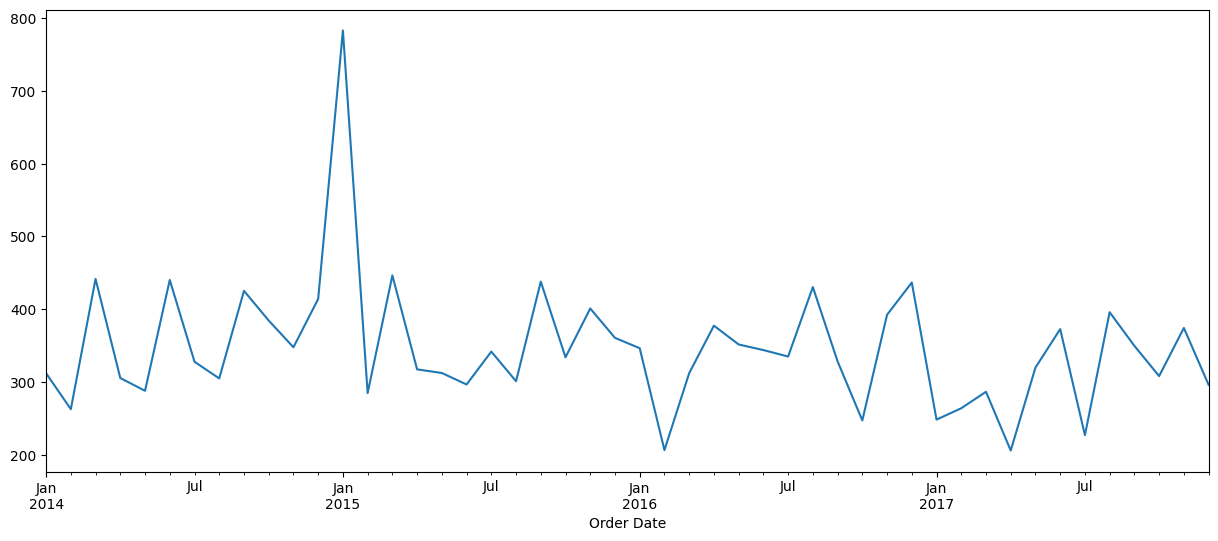

In [68]:
y.plot(figsize=(15,6))
plt.show()

From the above time-series data, notice patterns:

1. The time-series has a seasonality apttern, such that sales are low at the start of the year, but spike at the end
2. There exists an upward trend within any single year

Let's further visualize our decomposed time-series data

<Figure size 1500x1000 with 0 Axes>

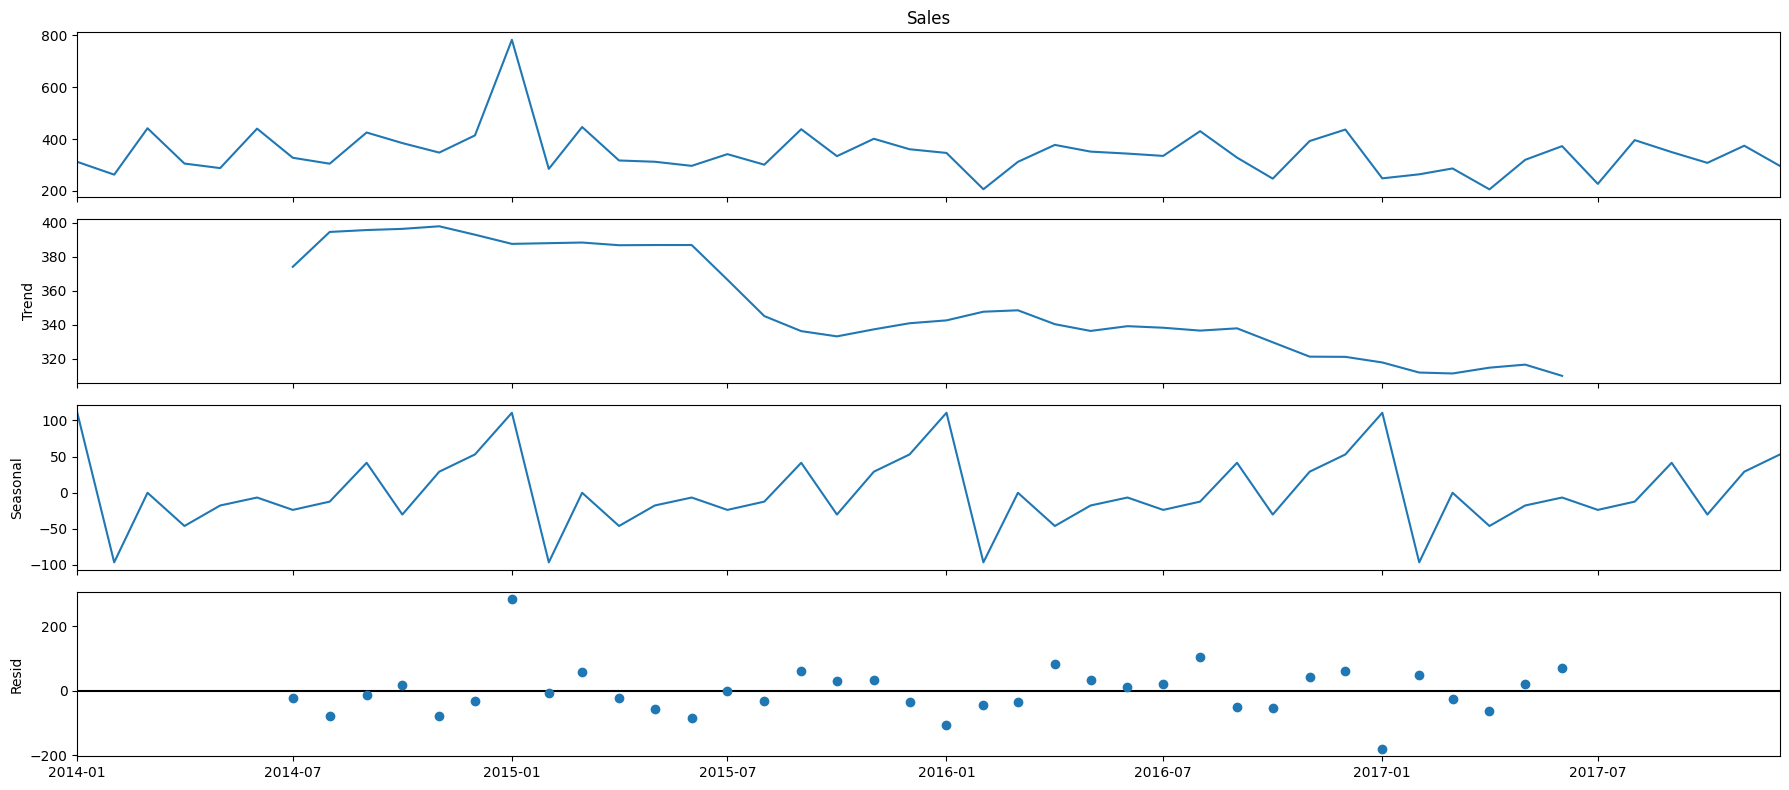

In [69]:
# We will use the time series analysis model from Statsmodels to perform seasonal decompose
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
plt.figure(figsize=(15,10))
fig = decomposition.plot()
plt.show()

## Time Series Forecasting with ARIMA

We will utilized the Autoregression Integrated Moving Averages (ARIMA) model to perform time-series forecasting.

ARIMA models denoted with parameters (p, d, q) each representing seasonality, trend, and noise in the data.

In the following code cell, we will define p,d, and q paramters for two types of ARIMA models. The first being non-seasonal and the latter being seasonal. This allows us to fit a SARIMA model that accounts for both seasonal and non-seasonal factors in the data - particularity useful for datasets exhibiting seasonal trends.

In [70]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

# Specifies a seasonal period of 12 months - length of the seasonal cycle
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for Seasonal ARIMA')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[3]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[4]} x {seasonal_pdq[4]}')



Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


The following step uses "grid search" to find the optimal parameter combination for our model

In [71]:
results = {

  'params': [],
  'seasonal_param': [],
  'AIC': []
}

for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:
        mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit()
        results['params'].append(param)
        results['seasonal_param'].append(param_seasonal)
        results['AIC'].append(res.aic)
        print(f'ARIMA {param}x{param_seasonal} - AIC:{results.aic}')
      except:
        continue

Akaike Information Criterion, is a statistical measure for model selection among a set of models - particularily useful in context of time series analysis and other statistical models being compared to identify which one best fits data.

**Purpose** : Quantify goodness of fit while penalizing for number of parameters used (helps with overfitting).

**Formula** : $AIC = 2k - 2ln(L)$ where:
- k is the number of parameters
- ln(L) is the natural log of the likelihood function of the model

In [75]:
idx = results['AIC'].index(min(results['AIC']))
print(idx, results['AIC'][idx])

27 251.24707755083625


In [74]:
print(results['params'][idx])
print(results['seasonal_param'][idx])

(0, 1, 1)
(0, 1, 1, 12)


## Fitting the ARIMA Model

Now that we have identified the best set of params, let's fit the ARIMA model

In [88]:
model = sm.tsa.statespace.SARIMAX(y,
                                  order=(0,1,1),
                                  seasonal_order=(0,1,1,12),
                                  enforce_stationarity=False,
                                  enforece_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -122.624
Date:                            Mon, 06 May 2024   AIC                            251.247
Time:                                    22:48:02   BIC                            254.381
Sample:                                01-01-2014   HQIC                           251.927
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9990     11.568     -0.086      0.931     -23.671      21.674
ma.S.L12      -0.0141      0.173     -0.082      0.935      -0.352       0.324
sigma2      6623.4141   7.68e+04      0.086      0.931   -1.44e+05    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.86   Prob(JB):                         0.62
Heteroskedasticity (H):               0.52   Skew:                            -0.29
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can attempt to look at the `plot_diagnostics` however, in our case, there are not enough datapoints.

## Validating Forecasts

Compare the predicted sales to real sales

In [89]:
# Predictiosn are calcualted using the observed values up to the start point the nrely on predicted values for subsequent time steps
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)

# Retrieve COnfidence Interal for predictions
pred_ci = pred.conf_int()

pred_ci

,lower Sales,upper Sales
Order Date,,
2017-01-01,162.948596,488.762649
2017-02-01,14.875729,340.401606
2017-03-01,124.922804,450.181033
2017-04-01,187.530476,512.541724
2017-05-01,156.672016,481.454647
2017-06-01,149.067194,473.637597
2017-07-01,143.167863,467.540726
2017-08-01,234.069874,558.258410
2017-09-01,135.532503,459.548646


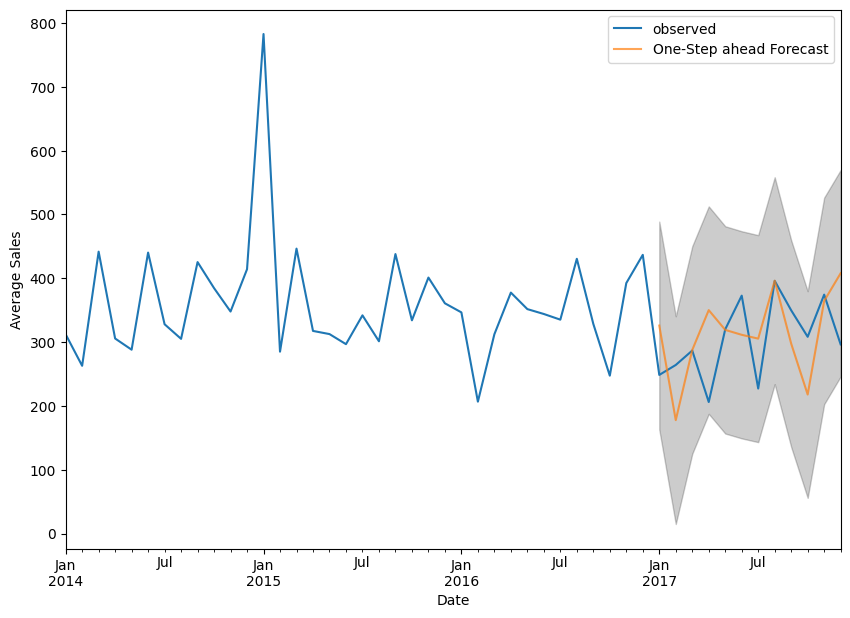

In [91]:
# plot the original dataset
ax = y['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-Step ahead Forecast', alpha=0.7, figsize=(10, 7))

# Shae in the confidence intervals with grey background
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='k',
                alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Average Sales')
plt.legend()

plt.show()

Calculating Error between Predictions and Ground Truth

In [92]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The mean squred error is {mse:.2f}')

The mean squred error is 5626.35


In [93]:
print(f'The Root Mean Squared Error is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error is 75.01


## Producing and Visualizing Forecasts

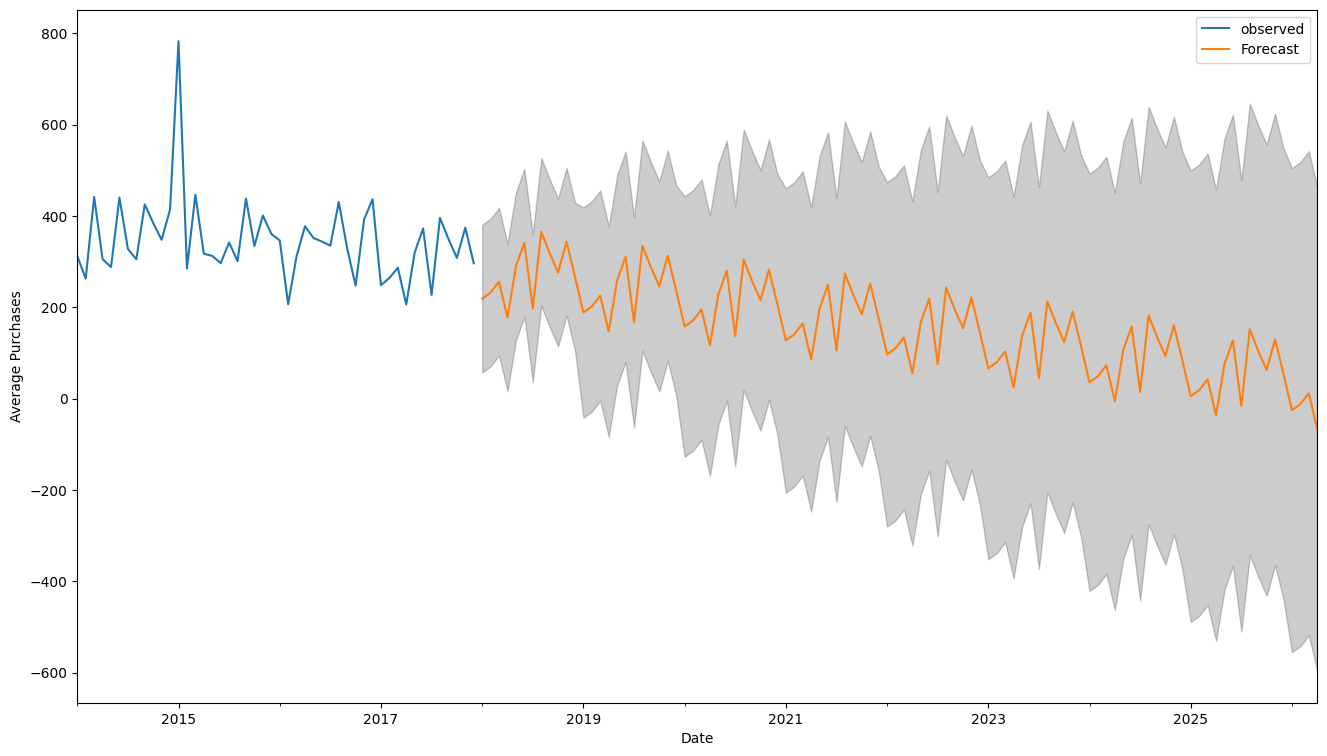

In [95]:
# Obtain the next 100 months worth of predictions
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(16,9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='k',
                alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Average Purchases')

plt.legend()
plt.show()

This seems to align with with our time series decomposition as we saw a downward trend in number of sales, however an increasing trend over the duration of each season. As we forecast further into the future, the confidence intervals are larger - higher uncertainty.

# Furniture vs Office Supplies

Let's compare the forecasts for two categories, furniture and office supplies

In [96]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

## Data Exploration

In [98]:
cols = ['Order Date', 'Sales']

# Select the desired columns
furniture = furniture[cols]
office = office[cols]

In [99]:
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [102]:
# Aggregate the sales for each day
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

# Average of each month
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

# Create New Data Frames
furniture = pd.DataFrame({'Order Date': y_furniture.index, 'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

# Merge two Data Frames
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()


,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


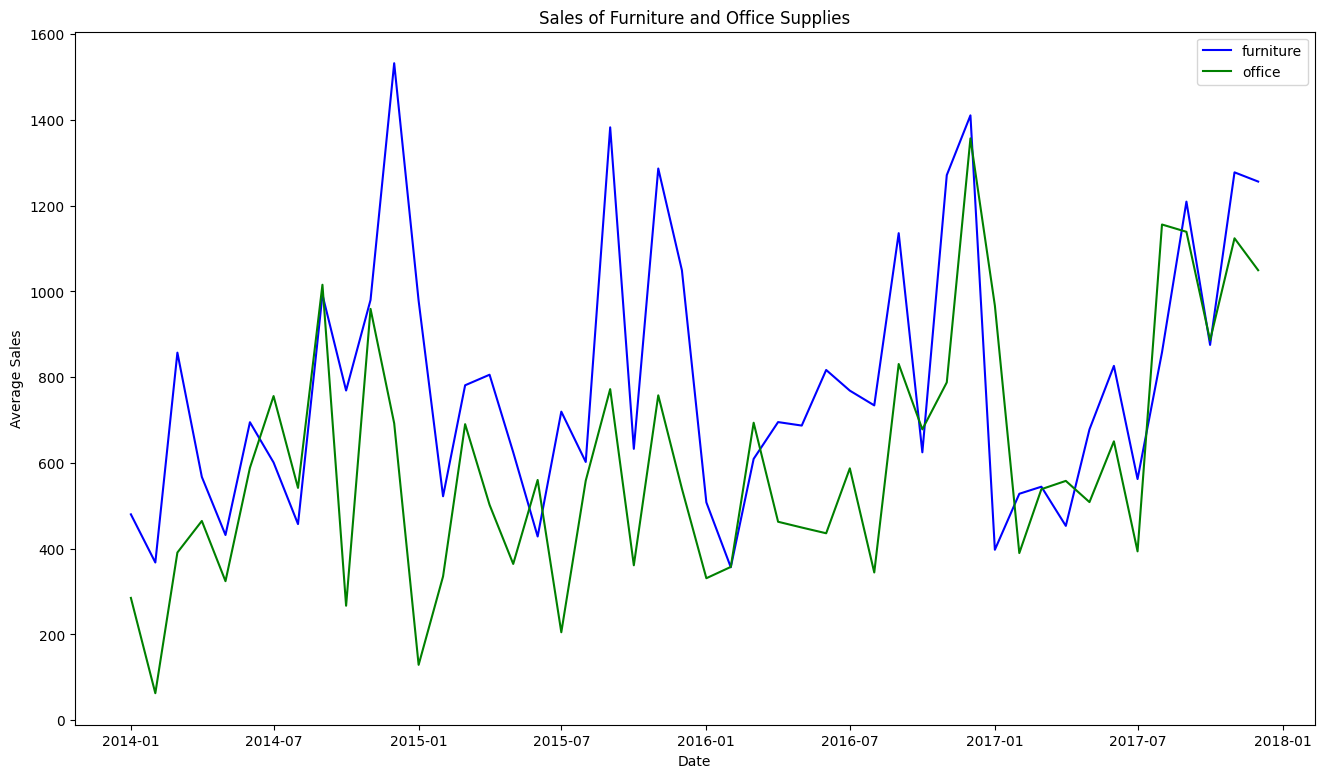

In [106]:
plt.figure(figsize=(16,9))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label='furniture')
plt.plot(store['Order Date'], store['office_sales'], 'g-', label='office')

plt.xlabel('Date')
plt.ylabel("Average Sales")
plt.title('Sales of Furniture and Office Supplies')
plt.legend()

Notice how the sales of office supplies and furniture share similar seasonal pattern - low in beginning and higher towards the end. It makes sense that furniture has more sales than office supplies. Howerver, we see at some points the sale of office supplies surpassing furniture.

In [108]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print(f'Office supplies first time produced higher sales than furniture {first_date}')

Office supplies first time produced higher sales than furniture 2014-07-01 00:00:00


## Time Series Modelling with Prophet

Phrophet is a forecasting tool released by Facebook in 2017 designed for analyzing time-series that display patterns on differnt time scales (yearly, weekyl, daily). It also includes capabilities for modelling the effects of holidays on a time-series and implementing custom changepoints.

In [110]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

# Create predictions for the next 36 months
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=26, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqhwk1u5/x9mlz5hn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqhwk1u5/92jbqmil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45425', 'data', 'file=/tmp/tmptqhwk1u5/x9mlz5hn.json', 'init=/tmp/tmptqhwk1u5/92jbqmil.json', 'output', 'file=/tmp/tmptqhwk1u5/prophet_modelevg2ogo5/prophet_model-20240507015722.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

Text(0.5, 1.0, 'Furniture Sales')

<Figure size 1600x900 with 0 Axes>

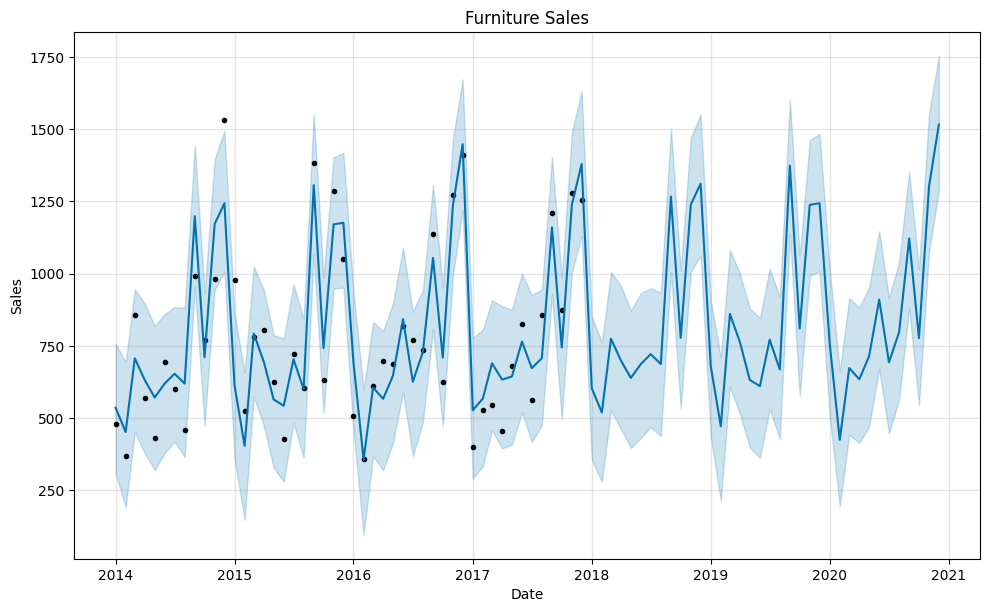

In [111]:
plt.figure(figsize=(16,9))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')

Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1600x900 with 0 Axes>

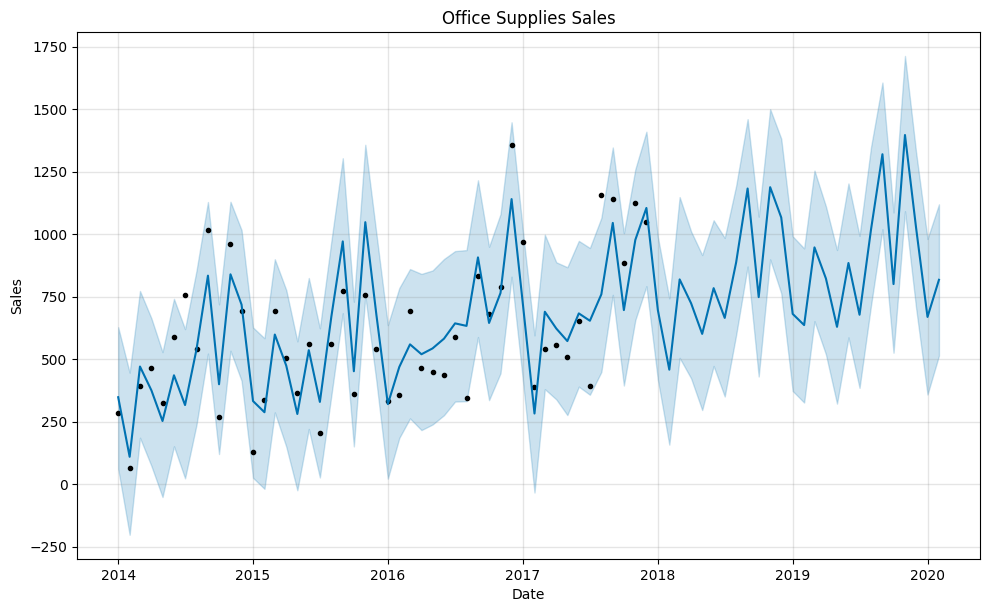

In [112]:
plt.figure(figsize=(16,9))
office_model.plot(office_forecast, xlabel='Date', ylabel='Sales')
plt.title('Office Supplies Sales')

## Compare Forecasts

After obtaining the forecasts for two categories, let's join the two plots

In [114]:
# Create a list of all possible column names
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

# Setup new dfs
merge_funiture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_funiture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

# Merge the dfs based on the date column in eact df
forecast = pd.merge(merge_funiture_forecast, merge_office_forecast, how='inner', left_on='furniture_ds', right_on='office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,308.462010,756.980043,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,190.297953,694.601730,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,451.716542,945.552183,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,375.939459,895.390102,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,320.136569,818.602830,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


## Trend Forecast Visualization

Text(0.5, 1.0, 'Furniture vs Office Supplies Sales Trend')

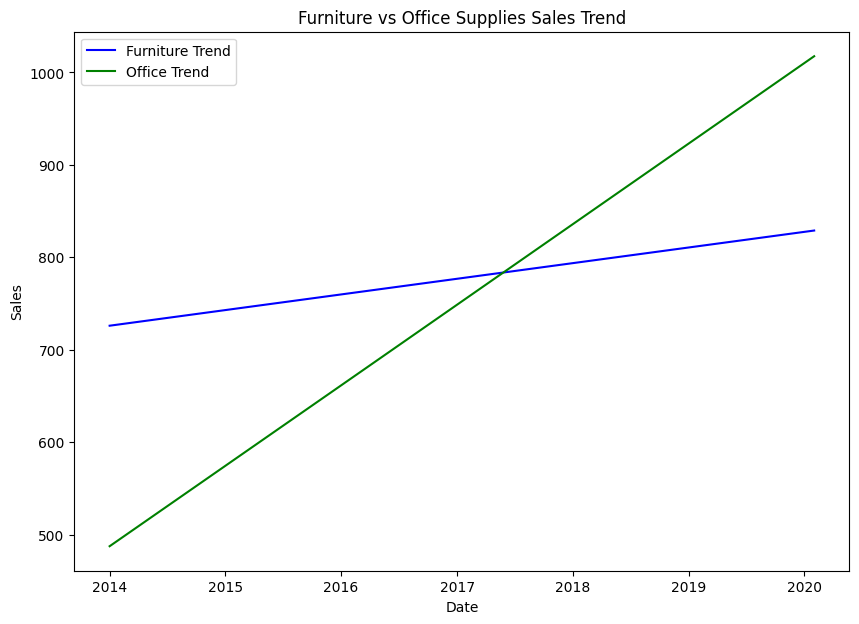

In [118]:
plt.figure(figsize=(10,7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label="Furniture Trend")
plt.plot(forecast['Date'], forecast['office_trend'], 'g-', label='Office Trend')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies Sales Trend')

Text(0.5, 1.0, 'Furniture vs Office Supplies Sales Average Estimate')

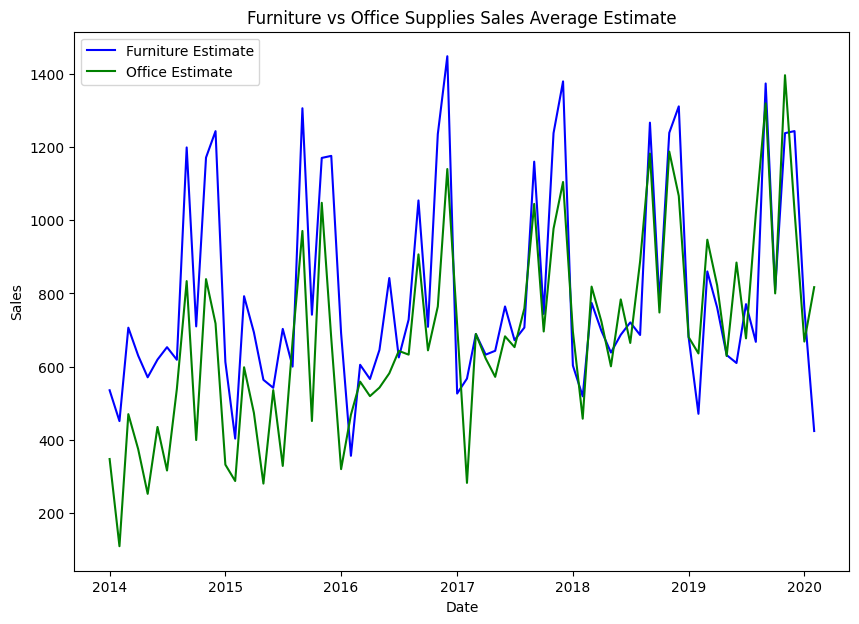

In [120]:
plt.figure(figsize=(10,7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label='Furniture Estimate')
plt.plot(forecast['Date'], forecast['office_yhat'], 'g-', label='Office Estimate')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies Sales Average Estimate')

Inspect different trends of the two categories

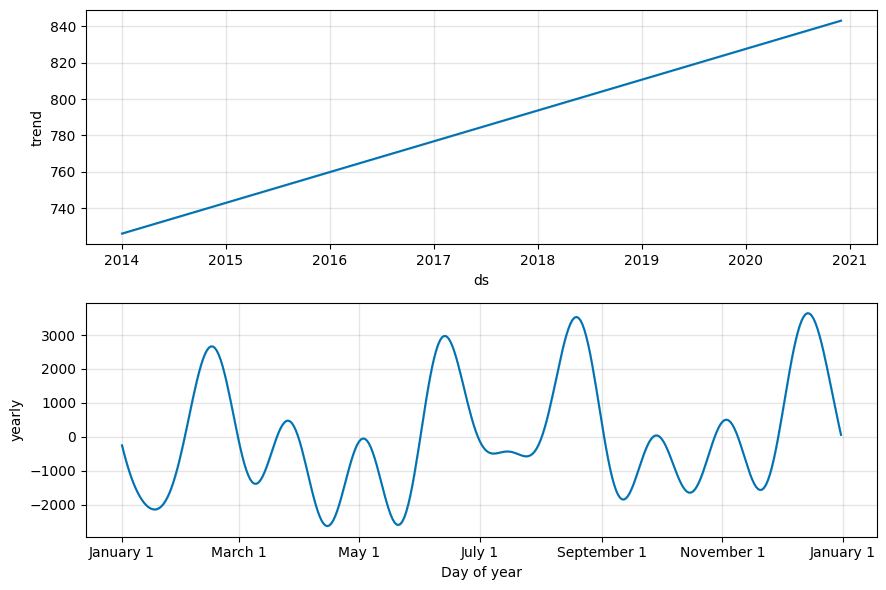

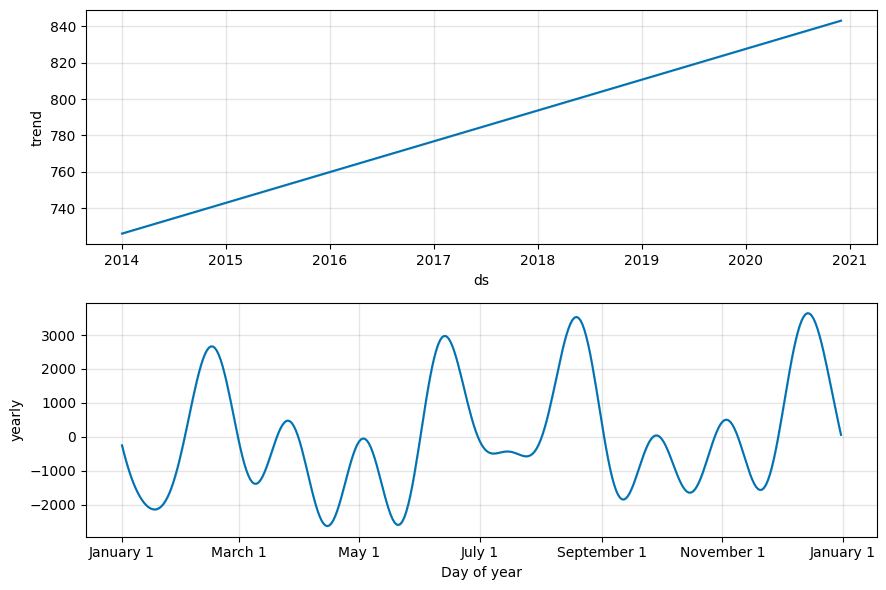

In [121]:
furniture_model.plot_components(furniture_forecast)

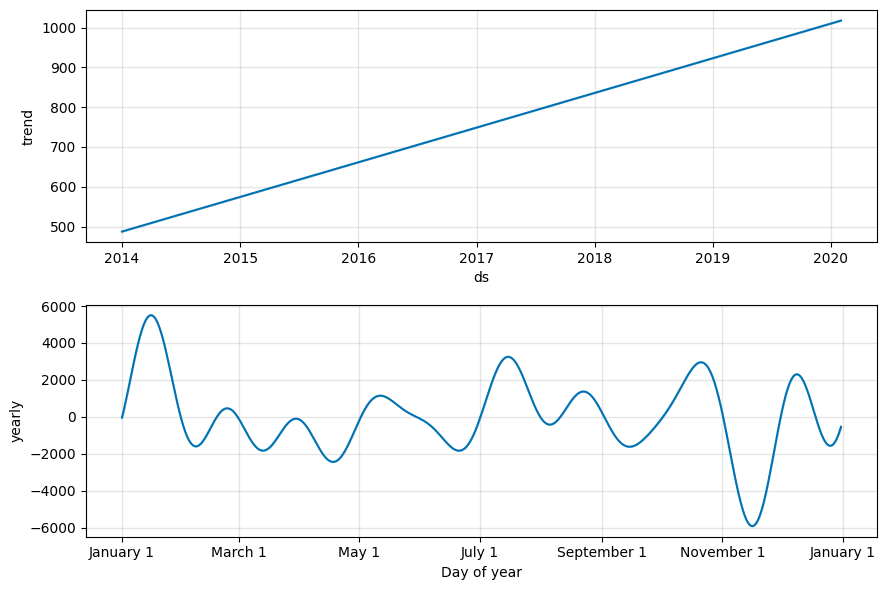

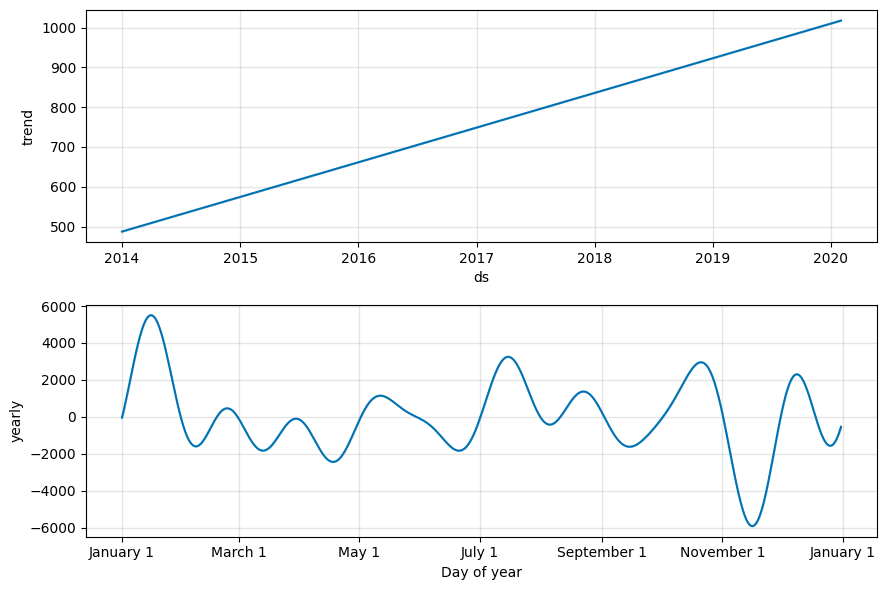

In [124]:
office_model.plot_components(office_forecast)